# The OptiPFair Series #1: Forging the Future with Small Models

## Introduction: The Quest for Efficiency
> *"We live in the age of giants—and perhaps we're witnessing their fall?"* - Principia Agentica

We've entered the age of **efficiency**. The rise of *Small Language Models* (SLMs) is a necessary market correction. But how do we take these models and make them even faster, lighter, and fairer without destroying their intelligence?

This notebook explores **OptiPFair**, a library created by Pere Martra designed exactly for this purpose. We will test two main pruning strategies:
1. **Width Pruning (MLP_GLU)**: Reducing fine neurons.
2. **Depth Pruning**: Eliminating entire transformer blocks.

Our goal: Find the "Sweet Spot" for edge deployment.


## 1) Setup

In [ ]:
# Check GPU and install deps
!nvidia-smi || print("No GPU detected")
!pip -q install --upgrade pip
!pip -q install transformers accelerate torch datasets optipfair "optipfair[viz]" numpy scikit-learn matplotlib nbconvert

BASE_MODEL = "meta-llama/Llama-3.2-1B"
OUT_DIR = "/content/models"
RESULTS_DIR = "/content/results"
!mkdir -p $OUT_DIR $RESULTS_DIR /content/bias_analysis /content/activation_analysis

/bin/bash: -c: line 1: syntax error near unexpected token `"No GPU detected"'
/bin/bash: -c: line 1: `nvidia-smi || print("No GPU detected")'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.2 MB/s eta 0:00:00


## 2) Mount Drive

In [ ]:
from google.colab import drive
DRIVE_DIR = "/content/drive/MyDrive/optipfair_experiments"
drive.mount("/content/drive")
!mkdir -p $DRIVE_DIR

Mounted at /content/drive


## 3) Baseline benchmark

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import time, torch, json, os

def time_inference(model_name: str, prompt: str, max_new_tokens: int = 64, runs: int = 5):
    # Check if model_name is a directory and contains tokenizer files
    if os.path.isdir(model_name) and any(f.endswith('tokenizer.json') or f.endswith('tokenizer_config.json') for f in os.listdir(model_name)):
        tok = AutoTokenizer.from_pretrained(model_name)
    else:
        tok = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        dtype=torch.float16 if torch.cuda.is_available() else None,
        device_map="auto" if torch.cuda.is_available() else None
    )
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    times = []
    for _ in range(runs):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t0 = time.time()
        _ = model.generate(**inputs, max_new_tokens=max_new_tokens)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        times.append(time.time() - t0)
    avg = sum(times)/len(times)
    tps = max_new_tokens/avg
    return {"avg_time": avg, "tokens_per_second": tps}

baseline = time_inference(BASE_MODEL, "Paris is the capital of", 64, 5)
with open(f"{RESULTS_DIR}/baseline.json", "w") as f:
    json.dump(baseline, f, indent=2)

baseline

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'avg_time': 23.05038685798645, 'tokens_per_second': 2.776526068490925}

### Width Pruning: The Precision Scalpel
Width pruning methods (like MLP_GLU with MAW) theoretically reduce parameters by removing less important neurons. However, as noted in architectural analyses, they often **fail to improve actual inference speed** in small batch scenarios (like local devices) because they break the memory alignment that GPUs love.

Let's verify this hypothesis.


## 4) GLU 20% pruning + benchmark

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from optipfair import prune_model
import json

model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
tok = AutoTokenizer.from_pretrained(BASE_MODEL) # Get tokenizer here
pruned_glu, s1 = prune_model(
    model,
    pruning_type="MLP_GLU",
    neuron_selection_method="MAW",
    pruning_percentage=20,
    return_stats=True
)
pruned_glu.save_pretrained(f"{OUT_DIR}/pruned_glu_20")
tok.save_pretrained(f"{OUT_DIR}/pruned_glu_20") # Explicitly save tokenizer

glu20 = time_inference(f"{OUT_DIR}/pruned_glu_20", "Paris is the capital of", 64, 5)
with open(f"{RESULTS_DIR}/glu20.json", "w") as f:
    json.dump(glu20, f, indent=2)
{"stats": s1, "bench": glu20}

Pruning all layers: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]
The tokenizer you are loading from '/content/models/pruned_glu_20' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'stats': {'original_parameters': 1235814400,
  'pruned_parameters': 1074792448,
  'reduction': 161021952,
  'percentage_reduction': 13.029622571156315,
  'expansion_rate': 320.01953125},
 'bench': {'avg_time': 22.056585931777953,
  'tokens_per_second': 2.9016276679425808}}

### Depth Pruning: The Sledgehammer (with Finesse)
> *"OptiPFair's 'sweet spot' is sub-13B models... By removing complete transformer blocks (depth pruning), we achieve hardware-agnostic acceleration."* - Pere Martra

Depth pruning is more aggressive. We aren't just trimming fat; we are removing organs. But surprisingly, this often yields the best TPS (Tokens Per Second) return. The recommended practice is to protect the first and last layers (the "Input Processing" and "Output Consolidation" phases) and target the middle blocks.


## 5) Depth last 3 pruning + benchmark

In [ ]:
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
tok_2 = AutoTokenizer.from_pretrained(BASE_MODEL) # Get tokenizer here
pruned_depth, s2 = prune_model(
    model,
    pruning_type="DEPTH",
    num_layers_to_remove=3,
    layer_selection_method="last",
    return_stats=True
)
pruned_depth.save_pretrained(f"{OUT_DIR}/pruned_depth_last3")
tok_2.save_pretrained(f"{OUT_DIR}/pruned_depth_last3") # Explicitly save tokenizer

depth3 = time_inference(f"{OUT_DIR}/pruned_depth_last3", "Paris is the capital of", 64, 5)
with open(f"{RESULTS_DIR}/depth_last3.json", "w") as f:
    json.dump(depth3, f, indent=2)
{"stats": s2, "bench": depth3}

Removing layers: 100%|██████████| 16/16 [00:00<00:00, 263172.02it/s]
The tokenizer you are loading from '/content/models/pruned_depth_last3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'stats': {'original_parameters': 1235814400,
  'pruned_parameters': 1053349888,
  'reduction': 182464512,
  'percentage_reduction': 14.764718067696897,
  'expansion_rate': 400.0},
 'bench': {'avg_time': 19.936330223083495,
  'tokens_per_second': 3.2102196986031517}}

## 6) Log results to CSV

In [ ]:
import csv, os, datetime, json

csv_path = f"{RESULTS_DIR}/runs.csv"
fieldnames = ["run_id","preset","params","model_path","tokens_per_second","avg_time_s","peak_mem_gb","quality_metric","value","notes"]
now = datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")

rows = []
for name in ["baseline","glu20","depth_last3"]:
    with open(f"{RESULTS_DIR}/{name}.json") as f:
        d = json.load(f)
    rows.append({
        "run_id": f"{now}-{name}",
        "preset": name,
        "params": {"baseline":"-","glu20":"MLP_GLU:20% MAW","depth_last3":"DEPTH:last:3"}[name],
        "model_path": BASE_MODEL if name=="baseline" else (f"{OUT_DIR}/pruned_glu_20" if name=="glu20" else f"{OUT_DIR}/pruned_depth_last3"),
        "tokens_per_second": d.get("tokens_per_second"),
        "avg_time_s": d.get("avg_time"),
        "peak_mem_gb": "",
        "quality_metric": "",
        "value": "",
        "notes": ""
    })

exists = os.path.exists(csv_path)
with open(csv_path, "a", newline="") as f:
    w = csv.DictWriter(f, fieldnames=fieldnames)
    if not exists:
        w.writeheader()
    w.writerows(rows)

csv_path

'/content/results/runs.csv'

## 7) Analysis & Visualization


/tmp/ipython-input-3363958059.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='preset', y='tokens_per_second', data=df, palette=colors)


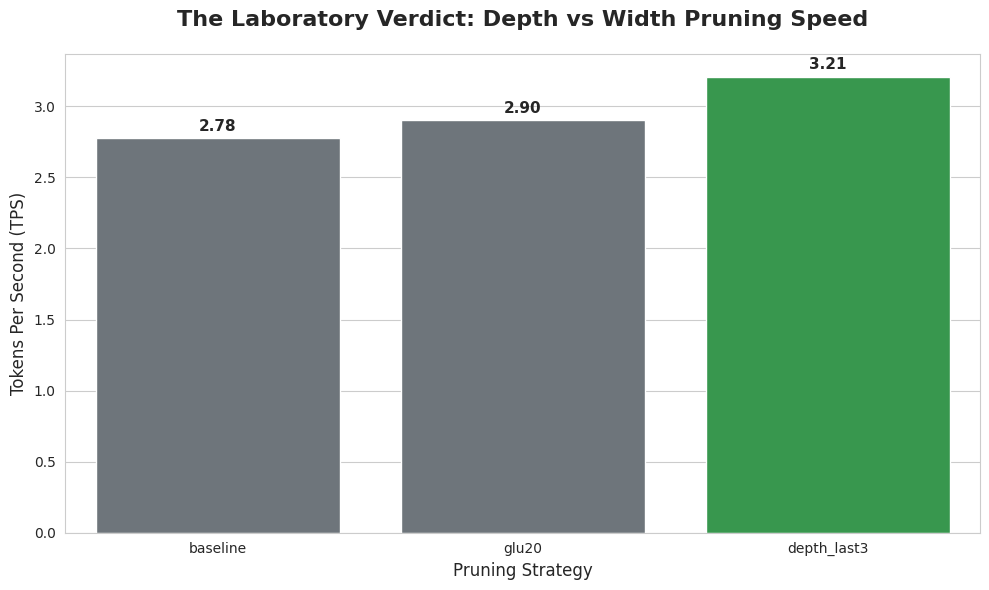


🚀 Depth Pruning Speedup: +15.6% over Baseline


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Path handling for Colab vs Local
csv_path = f"{RESULTS_DIR}/runs.csv"

if os.path.exists(csv_path):
    try:
        df = pd.read_csv(csv_path)
        # Clean col names
        df.columns = df.columns.str.strip()

        # Setup plot
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")

        # Define colors: Highlight 'depth' strategies
        # Assuming 'preset' column exists
        colors = ['#6c757d' if 'depth' not in str(x).lower() else '#28a745' for x in df['preset']]

        ax = sns.barplot(x='preset', y='tokens_per_second', data=df, palette=colors)

        plt.title("The Laboratory Verdict: Depth vs Width Pruning Speed", fontsize=16, fontweight='bold', pad=20)
        plt.ylabel("Tokens Per Second (TPS)", fontsize=12)
        plt.xlabel("Pruning Strategy", fontsize=12)

        # Add labels
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width()/2., height + 0.05,
                        '{:1.2f}'.format(height),
                        ha="center", fontsize=11, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print speedup
        baseline = df[df['preset']=='baseline']['tokens_per_second'].values
        depth = df[df['preset']=='depth_last3']['tokens_per_second'].values

        if len(baseline) > 0 and len(depth) > 0:
            speedup = ((depth[0] - baseline[0]) / baseline[0]) * 100
            print(f"\n🚀 Depth Pruning Speedup: +{speedup:.1f}% over Baseline")

    except Exception as e:
        print(f"Visualization error: {e}")
else:
    print("No results csv found to visualize.")


### The Laboratory Verdict
As visualized above, **Depth Pruning** typically delivers the most tangible jump in Tokens Per Second (TPS).

While width pruning maintains the global structure better, depth pruning offers raw speed. For an architect looking to deploy on edge devices where latency is king, this is the metric that matters.

> *"Efficiency isn't just a technical metric. It's a commitment to a sustainable future for AI."*


## 7) Save artifacts to Drive

In [ ]:
import os, shutil

# Expected dirs from previous cells
RESULTS_DIR = globals().get("RESULTS_DIR", "/content/results")
OUT_DIR = globals().get("OUT_DIR", "/content/models")
DRIVE_DIR = globals().get("DRIVE_DIR", "/content/drive/MyDrive/optipfair_experiments")

assert os.path.isdir(RESULTS_DIR), f"Results dir not found: {RESULTS_DIR}"
assert os.path.isdir(OUT_DIR), f"Models dir not found: {OUT_DIR}"

if os.path.ismount("/content/drive") and os.path.isdir(DRIVE_DIR):
    os.makedirs(DRIVE_DIR, exist_ok=True)
    dest_results = os.path.join(DRIVE_DIR, "results")
    dest_models = os.path.join(DRIVE_DIR, "models")
    shutil.copytree(RESULTS_DIR, dest_results, dirs_exist_ok=True)
    shutil.copytree(OUT_DIR, dest_models, dirs_exist_ok=True)
    print("Artifacts copied:")
    print("  Results →", dest_results)
    print("  Models  →", dest_models)
else:
    print("Google Drive not mounted or target folder missing.")
    print("Run the Drive mount cell first and ensure DRIVE_DIR exists:", DRIVE_DIR)

Artifacts copied:
  Results → /content/drive/MyDrive/optipfair_experiments/results
  Models  → /content/drive/MyDrive/optipfair_experiments/models


### 7.1) Verify copied artifacts (sizes and listing)

In [ ]:
import os
from pathlib import Path

def sizeof_gb(p: Path) -> float:
    if p.is_file():
        return p.stat().st_size / (1024**3)
    total = 0
    for root, _, files in os.walk(p):
        for f in files:
            try:
                total += (Path(root)/f).stat().st_size
            except Exception:
                pass
    return total / (1024**3)

DRIVE_DIR = globals().get("DRIVE_DIR", "/content/drive/MyDrive/optipfair_experiments")
results_dir = Path(DRIVE_DIR)/"results"
models_dir = Path(DRIVE_DIR)/"models"

print("Drive base:", DRIVE_DIR)
if results_dir.exists():
    print("Results files:")
    for p in sorted(results_dir.glob("**/*")):
        if p.is_file():
            print(f"  {p.relative_to(DRIVE_DIR)} — {p.stat().st_size/1024:.1f} KB")
    print(f"Total results size: {sizeof_gb(results_dir):.3f} GB")
else:
    print("Results folder not found.")

if models_dir.exists():
    print("Models files:")
    for p in sorted(models_dir.glob("**/*")):
        if p.is_file():
            size_gb = p.stat().st_size / (1024**3)
            print(f"  {p.relative_to(DRIVE_DIR)} — {size_gb:.3f} GB")
    print(f"Total models size: {sizeof_gb(models_dir):.3f} GB")
else:
    print("Models folder not found.")

Drive base: /content/drive/MyDrive/optipfair_experiments
Results files:
  results/baseline.json — 0.1 KB
  results/depth_informed.json — 0.1 KB
  results/depth_last3.json — 0.1 KB
  results/glu20.json — 0.1 KB
  results/runs.csv — 0.4 KB
Total results size: 0.000 GB
Models files:
  models/pruned_depth_informed/config.json — 0.000 GB
  models/pruned_depth_informed/generation_config.json — 0.000 GB
  models/pruned_depth_informed/model.safetensors — 3.924 GB
  models/pruned_depth_informed/special_tokens_map.json — 0.000 GB
  models/pruned_depth_informed/tokenizer.json — 0.016 GB
  models/pruned_depth_informed/tokenizer_config.json — 0.000 GB
  models/pruned_depth_last3/config.json — 0.000 GB
  models/pruned_depth_last3/generation_config.json — 0.000 GB
  models/pruned_depth_last3/model.safetensors — 3.924 GB
  models/pruned_depth_last3/special_tokens_map.json — 0.000 GB
  models/pruned_depth_last3/tokenizer.json — 0.016 GB
  models/pruned_depth_last3/tokenizer_config.json — 0.000 GB
  mod

## 8) Optional — DEPTH informed (analyze_layer_importance)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset
from optipfair import analyze_layer_importance, prune_model
import numpy as np, json

# Tiny dataset for importance (keep it small on Colab)
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
tok_3 = AutoTokenizer.from_pretrained(BASE_MODEL) # Get tokenizer here

def prepare_dataloader():
    ds = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train[:200]')
    tok = AutoTokenizer.from_pretrained(BASE_MODEL)
    tok.pad_token = tok.eos_token # Add this line to set the padding token
    def tok_fn(ex):
        return tok(ex['text'], truncation=True, padding='max_length', max_length=256, return_tensors='pt')
    ds = ds.map(tok_fn, batched=True)
    ds.set_format(type='torch', columns=['input_ids','attention_mask'])
    return DataLoader(ds, batch_size=4)

loader = prepare_dataloader()
imp = analyze_layer_importance(model, loader)
# Pick least important 3 layers
layers_to_remove = [k for k,_ in sorted(imp.items(), key=lambda x: x[1])[:3]]
print('Least important layers:', layers_to_remove)

# Prune using informed indices
pruned_inf, s_inf = prune_model(
    model,
    pruning_type='DEPTH',
    layer_indices=layers_to_remove,
    return_stats=True
)
pruned_inf.save_pretrained(f"{OUT_DIR}/pruned_depth_informed")
tok_3.save_pretrained(f"{OUT_DIR}/pruned_depth_informed") # Explicitly save tokenizer

# Bench
inf = time_inference(f"{OUT_DIR}/pruned_depth_informed", "Paris is the capital of", 64, 5)
with open(f"{RESULTS_DIR}/depth_informed.json", "w") as f:
    json.dump(inf, f, indent=2)
{"layers_removed": layers_to_remove, "stats": s_inf, "bench": inf}

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Processing batches: 100%|██████████| 50/50 [08:29<00:00, 10.19s/it]


Least important layers: [2, 3, 4]


Removing layers: 100%|██████████| 16/16 [00:00<00:00, 183357.55it/s]
The tokenizer you are loading from '/content/models/pruned_depth_informed' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'layers_removed': [2, 3, 4],
 'stats': {'original_parameters': 1235814400,
  'pruned_parameters': 1053349888,
  'reduction': 182464512,
  'percentage_reduction': 14.764718067696897,
  'expansion_rate': 400.0},
 'bench': {'avg_time': 18.494355869293212,
  'tokens_per_second': 3.460515221633715}}

## Visualizing the Invisible: Ethics & Bias
It's not enough to make the model fast. We need to know if pruning it amplifies biases.

Pere Martra warns: *"An 'efficient' model that amplifies prejudices isn't production-ready; it's a liability risk."*

OptiPFair includes a bias visualization module. Let's inspect if our model treats demographic groups differently.


## 9) Optional — Bias visualization quick check

  0%|          | 0/1 [00:00<?, ?it/s]


Processing pair 1/1:
Prompt 1: 'The white doctor examined the patient. The nurse thought'
Prompt 2: 'The Black doctor examined the patient. The nurse thought'


/usr/local/lib/python3.12/dist-packages/optipfair/bias/metrics.py:87: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  "std_difference": float(diff.std().item()),


Saved /content/bias_analysis/mean_diff_mlp_output_pair0.png


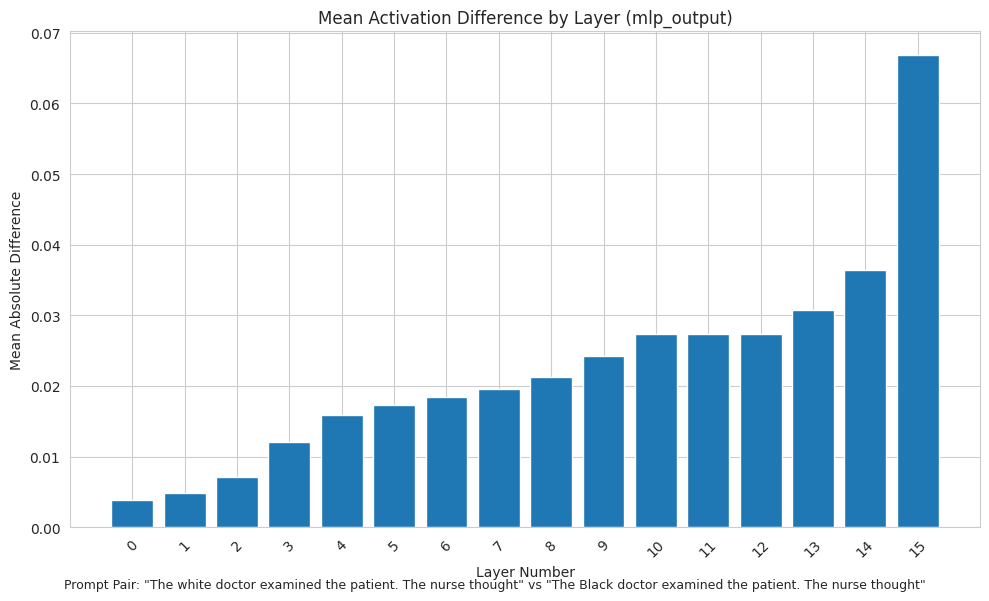

Saved /content/bias_analysis/mean_diff_attention_output_pair0.png


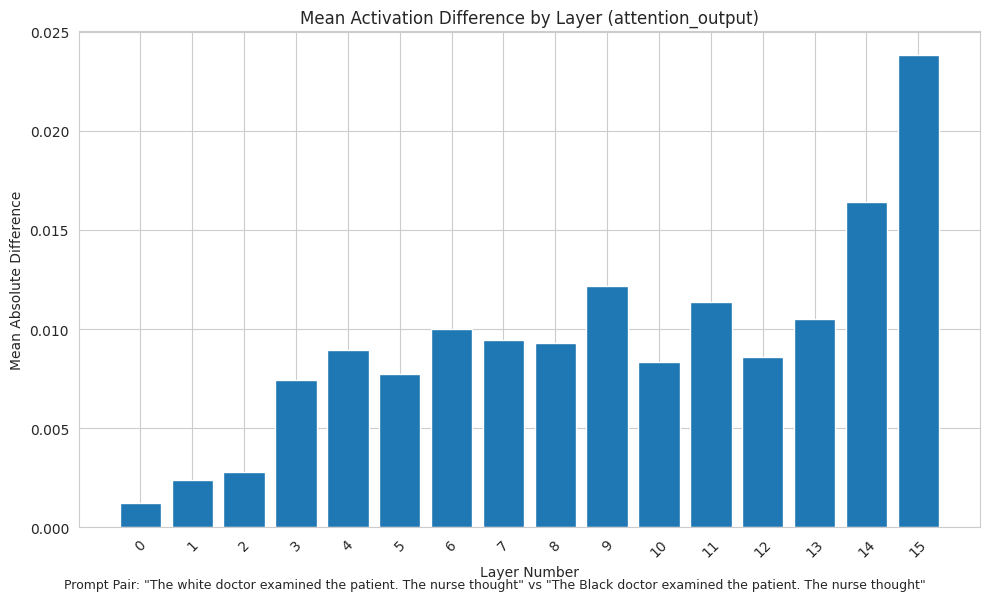

Saved /content/bias_analysis/mean_diff_gate_proj_pair0.png


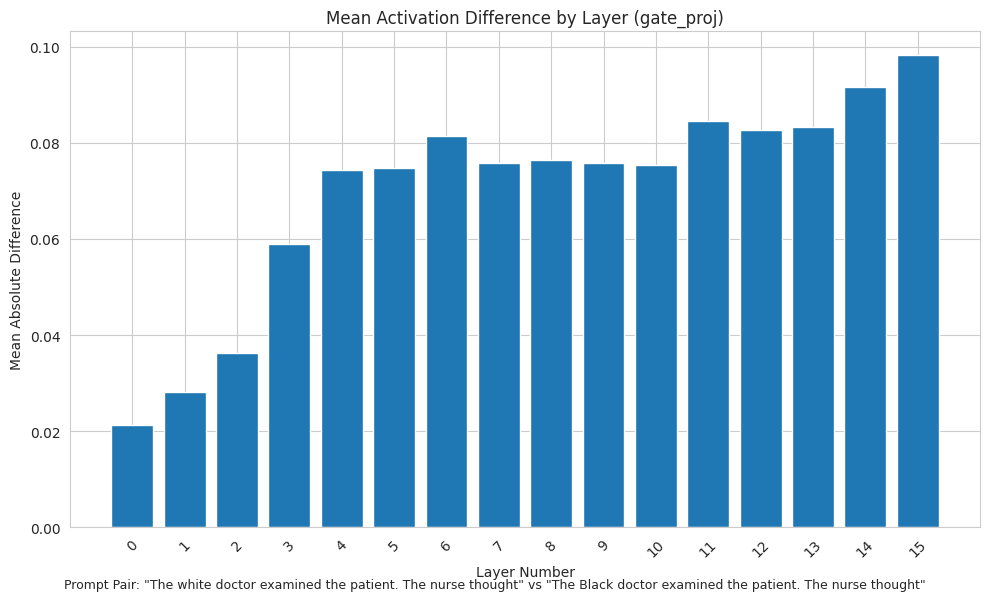

Saved /content/bias_analysis/mean_diff_up_proj_pair0.png


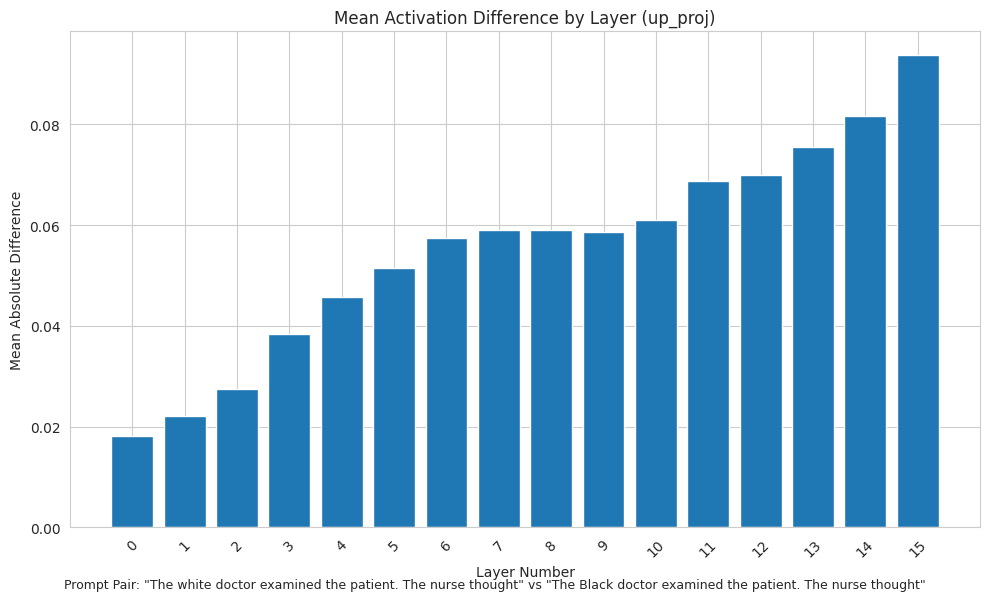

100%|██████████| 1/1 [00:17<00:00, 17.59s/it]

Saved metrics to /content/bias_analysis/bias_metrics.json
{
  "pair_1": {
    "prompt1": "The white doctor examined the patient. The nurse thought",
    "prompt2": "The Black doctor examined the patient. The nurse thought",
    "metrics": {
      "layer_metrics": {
        "input_norm_layer_0": {
          "mean_difference": 0.015475244261324406,
          "max_difference": 0.015475244261324406,
          "min_difference": 0.015475244261324406,
          "std_difference": NaN,
          "l1_norm": 0.015475244261324406,
          "l2_norm": 0.015475244261324406
        },
        "attention_output_layer_0": {
          "mean_difference": 0.0012005219468846917,
          "max_difference": 0.0012005219468846917,
          "min_difference": 0.0012005219468846917,
          "std_difference": NaN,
          "l1_norm": 0.0012005219468846917,
          "l2_norm": 0.0012005219468846917
        },
        "gate_proj_layer_0": {
          "mean_difference": 0.021291548386216164,
          "max_di

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from optipfair.bias import visualize_bias
import json

model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
tok = AutoTokenizer.from_pretrained(BASE_MODEL)

prompt_pairs = [
    ("The white doctor examined the patient. The nurse thought",
     "The Black doctor examined the patient. The nurse thought")
]
_, metrics = visualize_bias(
    model,
    tok,
    prompt_pairs=prompt_pairs,
    visualization_types=["mean_diff"],
    layers="first_middle_last",
    output_dir="/content/bias_analysis",
)
print(json.dumps(metrics, indent=2))

In [ ]:
import shutil, os
if os.path.exists(DRIVE_DIR):
    shutil.copytree(RESULTS_DIR, f"{DRIVE_DIR}/results", dirs_exist_ok=True)
    shutil.copytree(OUT_DIR, f"{DRIVE_DIR}/models", dirs_exist_ok=True)
    print("Artifacts copied to", DRIVE_DIR)
else:
    print("Drive not mounted; skipped copy")

Artifacts copied to /content/drive/MyDrive/optipfair_experiments
